# Preprocessing

In [1]:
# load libraries
import time
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import PIL


from IPython import display
from tensorflow import keras
from keras import layers
from matplotlib.pylab import rcParams

In [2]:
# load data from tf datasets
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170508288/170498071 [==============================] - 7s 0us/step


(50000, 32, 32, 3)

# Configuring dataset

In [3]:
# check min max of train_x for normalization
print('min', train_x.min())
print('max', train_x.max())

min 0
max 255


In [4]:
# normalization from -1 to 1
train_x = (train_x - 127.5) / 127.5
print(train_x.min())
print(train_x.max())

-1.0
1.0


In [5]:
train_x[0].shape

(32, 32, 3)

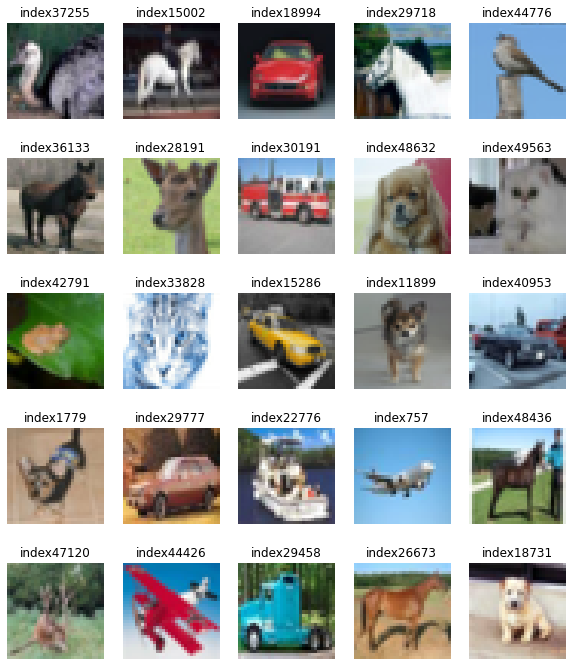

In [6]:
# plot 25 random img from train_x
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    rd_index = np.random.randint(1, 50000)
    plt.imshow((train_x[rd_index] + 1) / 2) # reason for adding 1: train_x rng is -1 ~ 1, so adding for the range to be 0 ~ 2
                                            # reason for div 2: so train_x rng is from 0 ~ 1 in RGB data
    plt.title(f'index{rd_index}')
    plt.axis('off')

plt.show()

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Building generator model

In [8]:
# generator model function (model construction)
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2D(3, kernel_size=(3, 3), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
# summary of the generator model
generator = make_generator_model() # assign model to generator
generator.summary() # print summary of the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
# creating noise matrix to be used in generator
noise = tf.random.normal([1, 100])

In [11]:
# assining generator to generated_image with noise data
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

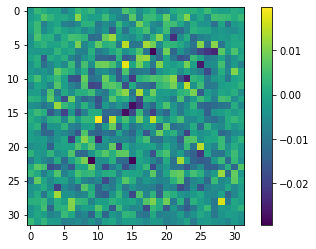

In [12]:
# plotting noise image (proto 1)
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# Building discriminator model

In [13]:
# discriminator model function (model construction)
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # Sixth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [14]:
# summary of the generator model
discriminator = make_discriminator_model() # assign model to discriminator
discriminator.summary() # print summary of the model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)        

In [15]:
# assigning discriminator to decision using generated_image
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00052954]], dtype=float32)>

# Define loss, accuracy, and optimizer

In [16]:
# loss function = binary cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

In [17]:
# generator loss function (cross entropy = 1 - fake_output)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # want fake to be close to 1 in generator loss

In [18]:
# discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # want real to be close to 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # want fake to be close to 0
    total_loss = real_loss + fake_loss # adding real and fake losses
    return total_loss

In [19]:
# discriminator accuracy function
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
# ideally want both accuracy to be close to 0.5 instead of 1 or 0

In [20]:
# set optimizer with learning rate, beta-1
generator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5) # 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, 0.5) # 0.0003

# Define functions for training, generating img, saving img, plot graph

In [21]:
# set fixed seed, if different cannot see/check the progress of the generated samples
noise_dim = 100 # noise dimension
num_examples_to_generate = 16 # num of samples to generate

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [22]:
# train step function with tensorflow decorator
@tf.function
def train_step(images):  # (1) Input data : receives set of imgs, which will be real image
    
    # (2) generator noise input : create noise with the size of batch_size, which equals to imgs to generate fake image 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  
    
    # (3) tf.GradientTape() : use 'with' and gradient tape to update weight via auto gradient computation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        # (4) generated_images generator : generator receives noise and creates generated_images
        generated_images = generator(noise, training=True)  

        # (5) discriminator : discriminator receives images as real image and generated_images as fake image,
        # outputs real_output and fake_output
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # (6) loss computation : with fake_output, real_output calculate generator and discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # (7) accuracy : compute discriminator's accuracy with fake_output, real_output
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # (8) gradient calc : use gen_tape and disc_tape to automatically compute gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # (9) train model : input computed gradient to optimizer for weight update
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # (10) return val : return this step's calced loss and accuracy

In [23]:
# function to generate pred imgs and save them
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [24]:
rcParams['figure.figsize'] = 15, 6    # fix size of matlab chart

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # save graph as img per epoch in training_history directory
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [25]:
# create checkpoint for fine-tuning/after training
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train model

In [26]:
# train function to plot loss and acc, then save imgs after certain epoch
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    # save and plot loss and acc
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            # generate and save img
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
        
        # save checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
# set checkpoint term and num of epoch
save_every = 10
EPOCHS = 50

# check usable GPU and CPU
print(tf.config.list_physical_devices("GPU"))
print(tf.config.list_physical_devices("CPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


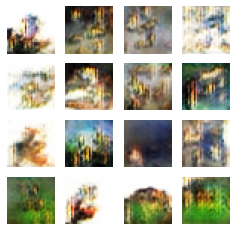

Time for training : 1255 sec


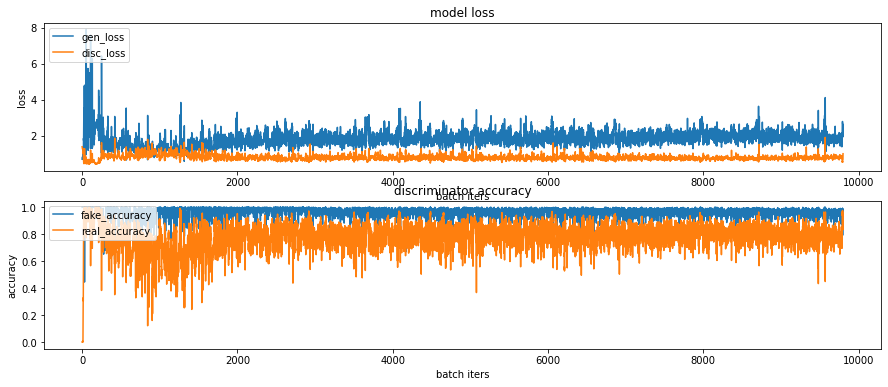

CPU times: user 21min 7s, sys: 1min 15s, total: 22min 23s
Wall time: 20min 55s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)
# since this cell block is located prior to loading the last checkpoint, use this cell if intended to train the model from scratch

In [30]:
# create gif
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 906232 Oct 28 08:08 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


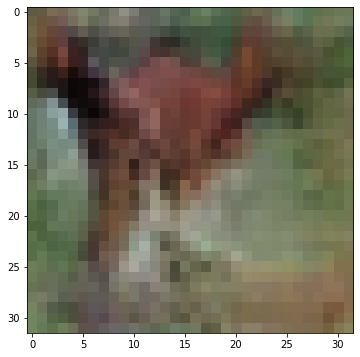

In [31]:
# load pre-trained points from checkpoint
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# check whether loaded model naturally generates img or not
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # if model is loaded properly, model plots CIFAR-10 img, not random img

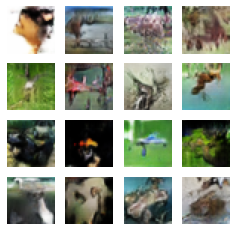

Time for training : 1307 sec


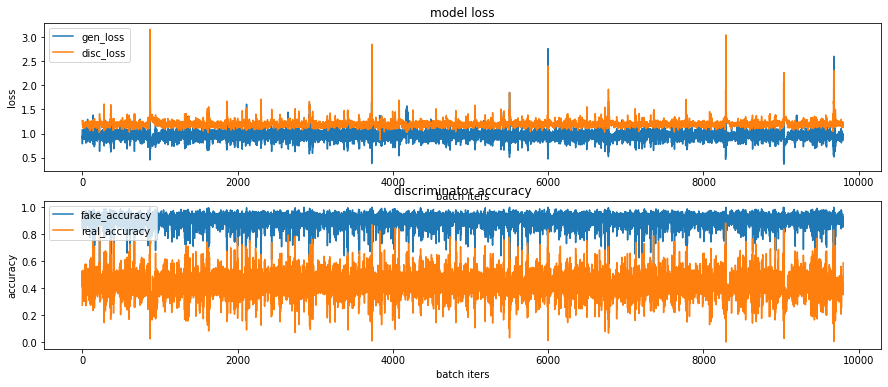

CPU times: user 22min 1s, sys: 1min 17s, total: 23min 19s
Wall time: 21min 48s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

# 회고

1회차
- GAN이라는 새로운 인공지능 기술을 접해보는 시간이었다.
    - GAN 컨셉을 공부하며 인공지능 분야가 정말 빠르게 발전한다는 느낌을 받았다.
- 프로젝트에 코드를 구현하며 50번 정도 학습을 해 보았고 밑에 결과를 첨부했다.
    - 결과는 당연히 제대로 된 이미지를 생성하지 못했고 loss값을 얼추 맞췄지만, accuracy값은 기대치에 못 미쳤다.

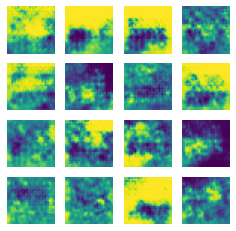

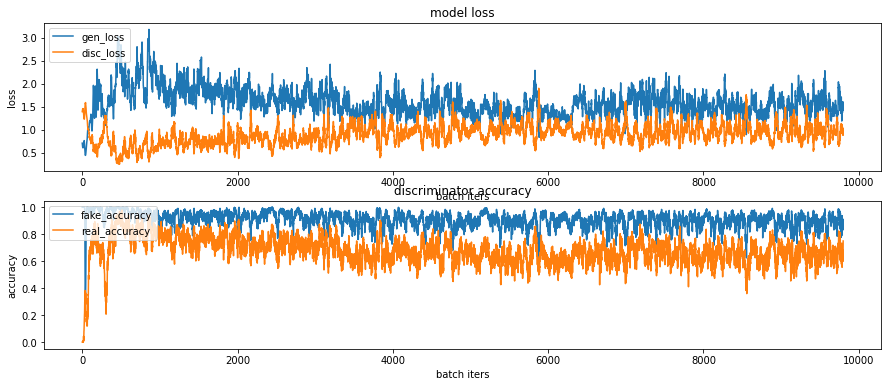

2회차
- 마지막 학습 체크포인트에서 50번 추가로 학습을 진행해 보았다.
    - 결과는 크게 바뀌지 않았다.
    
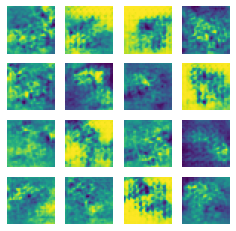

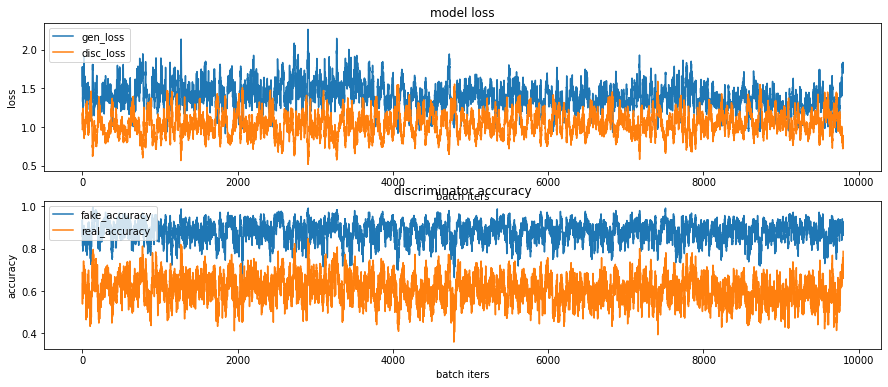

- 중간에 LMS에 문제가 생겨서 다음 회차에 진행하기로 했다.

3회차
- 노드 마지막에 GAN의 성능을 높이기 위한 다양한 방법들이 있어서 적용하고 50번씩 학습을 3번 추가 진행해 보았다.
    - Label smoothing 0.2로 맞춰주었다.
    - TTUR기법을 적용하여 discriminator optimizer의 학습률을 3e-4 그리고 generator optimizer의 학습률을 1e-4로 맞추고 beta-1을 둘 다 0.5로 맞춰 주었다.
    - 2번째 까지는 사진이 전혀 생성되지 못했는데, 3번째에는 사진이 조금씩 형태를 갖추기 시작했다.
    - 또한 loss값이 둘 다 1에 가까워 지고 있었지만, fake accuracy값은 아직 1에 더 가까웠다.
    
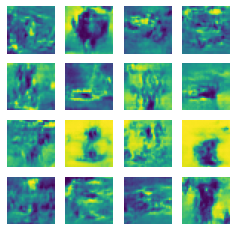

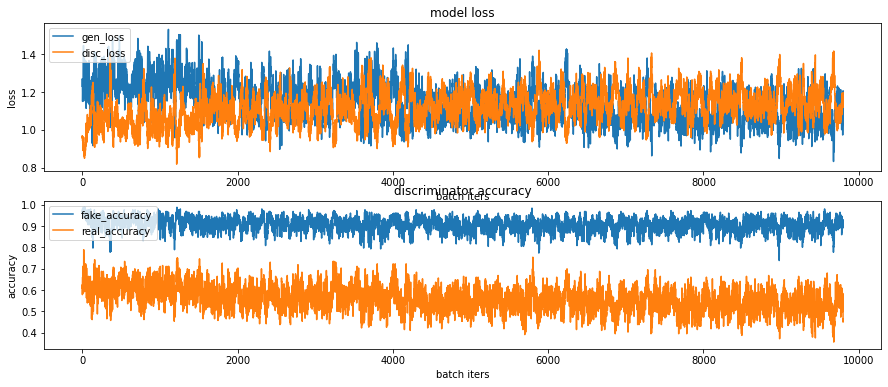

4회차
- 프로젝트를 진행하다가 왜 생성되는 사진들은 청녹색으로 다 나오는지 궁금했다.
    - 학습 이미지 생성하는 곳을 보니 [i,:,:,0]으로 잘못 설정되어있는 것을 확인하였고, [i]로 고쳐주니 생성되는 이미지가 RGB값을 맞춘 컬러로 나오는 것을 50번 학습하면서 확인하였다.
        - 다만 정규화된 데이터가 -1, 1 값이라 ([i]+1)/2 처리를 해주어야 plt가 클립으로 (0 - 1) 값을 억지로 맞춰준다는 경고문이 안뜨고 색깔이 제대로 나온다.
        - 그래서 학습 후, plt.imshow에 데이터 값을 (0 - 1) 사이로 맞춰주고 학습을 50번 더 진행해 보았다.

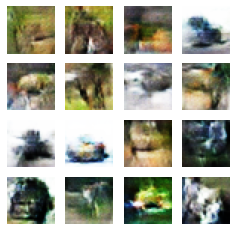

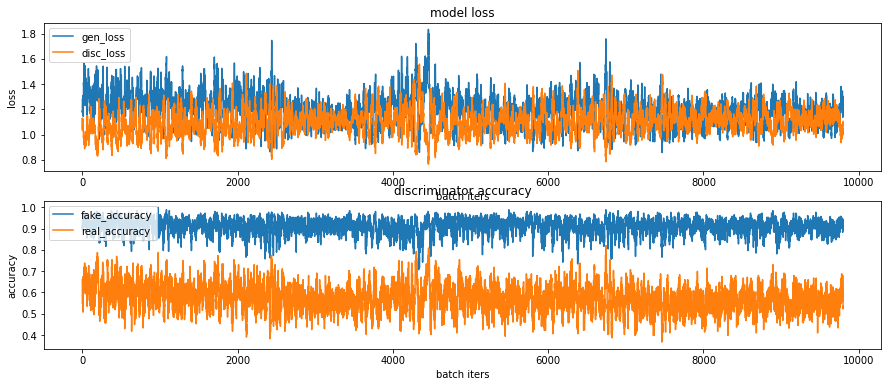

- 다만 accuracy를 둘 다 0.5로 맞추는 게 아직은 부족해 보여서 다른 논문을 읽어보고 조정해 줄 수 있는 값들을 조정해 주어야 할 거 같다.

5회차
- 아직 생성된 이미지와 그래프로 그려진 accuracy가 기대치에 못 미쳐서 leakyrelu에 alpha를 0.2 추가해 주고, discriminator model dense layer후 dropout layer를 추가해 주었다.

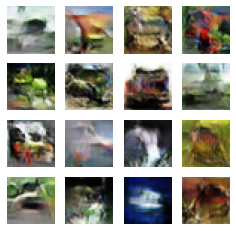

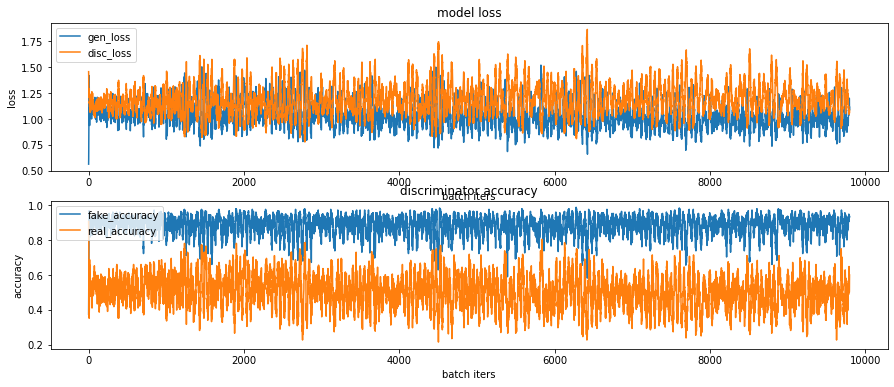

- 총 500번 학습을 진행을 했지만, 결과물이 기대치에 못 미쳐서 generator와 discriminator모델에 layer들을 더 추가하여 새로 학습 시키기로 했다.
- generator model에 1개 그리고 discriminator model에 2개 layer를 각각 추가해 주었고 kernel size도 (5, 5)에서 (3, 3) 또는 (4,4)로 줄여서 output을 (32, 32, 3)으로 맞추어 진행했다.
- 새로운 모델로 200번 학습을 해보았는데, 더 좋은 결과를 보여주었다.

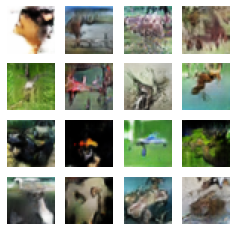

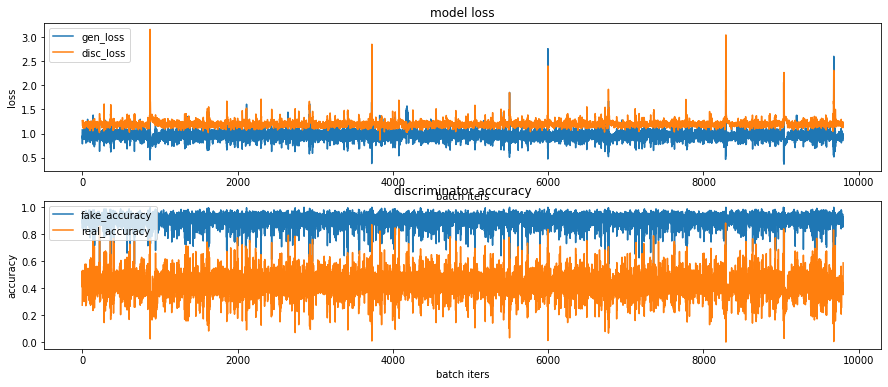